In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [3]:
import tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
import pandas as pd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
natural_gas_df = pd.read_csv('/content/drive/MyDrive/Datasets for June Project/Natural Gas.csv')
gold_df = pd.read_csv('/content/drive/MyDrive/Datasets for June Project/Gold.csv')
crude_oil_df = pd.read_csv('/content/drive/MyDrive/Datasets for June Project/Crude Oil.csv')
btc_usd_df = pd.read_csv('/content/drive/MyDrive/Datasets for June Project/BTC-USD.csv')
aapl_df = pd.read_csv('/content/drive/MyDrive/Datasets for June Project/AAPL.csv')

In [5]:
natural_gas_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,07/05/2024,2.319,2.421,2.440,2.315,NaN,-2.19%
1,07/04/2024,2.371,2.431,2.439,2.335,NaN,-1.94%
2,07/03/2024,2.418,2.466,2.480,2.410,125.89K,-0.70%
3,07/02/2024,2.435,2.476,2.484,2.415,154.26K,-1.74%
4,07/01/2024,2.478,2.576,2.602,2.471,181.93K,-4.73%


In [6]:
def preprocess_df(df, date_col, value_col, rename_dict=None):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.rename(columns={date_col: 'Date', value_col: 'Price'})
    if rename_dict:
        df = df.rename(columns=rename_dict)
    return df[['Date', 'Price']]

In [7]:
natural_gas_df = preprocess_df(natural_gas_df, 'Date', 'Price')
gold_df = preprocess_df(gold_df, 'Date', 'Price')
crude_oil_df = preprocess_df(crude_oil_df, 'Date', 'Price')
btc_usd_df = preprocess_df(btc_usd_df, 'Date', 'Close')
aapl_df = preprocess_df(aapl_df, 'Date', 'Close')

In [8]:
def ensure_ascending_order(df, date_col='Date'):
    if not df[date_col].is_monotonic_increasing:
        df = df.sort_values(by=date_col)
    return df

In [9]:
natural_gas_df = ensure_ascending_order(natural_gas_df)
gold_df = ensure_ascending_order(gold_df)
crude_oil_df = ensure_ascending_order(crude_oil_df)
btc_usd_df = ensure_ascending_order(btc_usd_df)
aapl_df = ensure_ascending_order(aapl_df)

In [10]:
natural_gas_df.head()

,Date,Price
1192,2020-01-01,2.179
1191,2020-01-02,2.122
1190,2020-01-03,2.130
1189,2020-01-06,2.135
1188,2020-01-07,2.162


In [11]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1134 non-null   datetime64[ns]
 1   Price   1134 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.8 KB


In [12]:
natural_gas_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 1192 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1193 non-null   datetime64[ns]
 1   Price   1193 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.0 KB


In [13]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1137 entries, 1136 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1137 non-null   datetime64[ns]
 1   Price   1137 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 26.6+ KB


In [14]:
gold_df['Price'] = gold_df['Price'].str.replace(',', '')
gold_df['Price'] = gold_df['Price'].astype(float)


In [15]:
gold_df['Price']

,Price
1136,1528.1
1135,1552.4
1134,1568.8
1133,1574.3
1132,1560.2
...,...
4,2338.9
3,2333.4
2,2369.4
1,2364.6


In [16]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1137 entries, 1136 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1137 non-null   datetime64[ns]
 1   Price   1137 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.6 KB


In [17]:
gold_df['Price'].isnull().sum()

0

In [18]:
display(natural_gas_df.head(), gold_df.head(), crude_oil_df.head(), btc_usd_df.head(), aapl_df.head())

,Date,Price
1192,2020-01-01,2.179
1191,2020-01-02,2.122
1190,2020-01-03,2.130
1189,2020-01-06,2.135
1188,2020-01-07,2.162


,Date,Price
1136,2020-01-02,1528.1
1135,2020-01-03,1552.4
1134,2020-01-06,1568.8
1133,2020-01-07,1574.3
1132,2020-01-08,1560.2


,Date,Price
1191,2020-01-01,61.33
1190,2020-01-02,61.18
1189,2020-01-03,63.05
1188,2020-01-06,63.27
1187,2020-01-07,62.70


,Date,Price
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383


,Date,Price
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501


In [19]:
natural_gas_df.isnull().sum()

,0
Date,0
Price,0


In [20]:
gold_df.isnull().sum()

,0
Date,0
Price,0


In [21]:
crude_oil_df.isnull().sum()

,0
Date,0
Price,0


In [22]:
btc_usd_df.isnull().sum()

,0
Date,0
Price,0


In [23]:
aapl_df.isnull().sum()

,0
Date,0
Price,0


In [24]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1134 non-null   datetime64[ns]
 1   Price   1134 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.8 KB


In [25]:
combined_df = pd.concat([
    natural_gas_df.assign(id='Natural Gas'),
    gold_df.assign(id='Gold'),
    crude_oil_df.assign(id='Crude Oil'),
    btc_usd_df.assign(id='Bitcoin'),
    aapl_df.assign(id='Apple')
])

combined_df = combined_df.rename(columns={'Date': 'time', 'Price': 'value'})

In [26]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6306 entries, 1192 to 1133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    6306 non-null   datetime64[ns]
 1   value   6306 non-null   float64       
 2   id      6306 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 197.1+ KB


In [27]:
combined_df.head()

,time,value,id
1192,2020-01-01,2.179,Natural Gas
1191,2020-01-02,2.122,Natural Gas
1190,2020-01-03,2.130,Natural Gas
1189,2020-01-06,2.135,Natural Gas
1188,2020-01-07,2.162,Natural Gas


In [28]:
combined_df.tail()

,time,value,id
1129,2024-06-28,210.619995,Apple
1130,2024-07-01,216.750000,Apple
1131,2024-07-02,220.270004,Apple
1132,2024-07-03,221.550003,Apple
1133,2024-07-05,226.339996,Apple


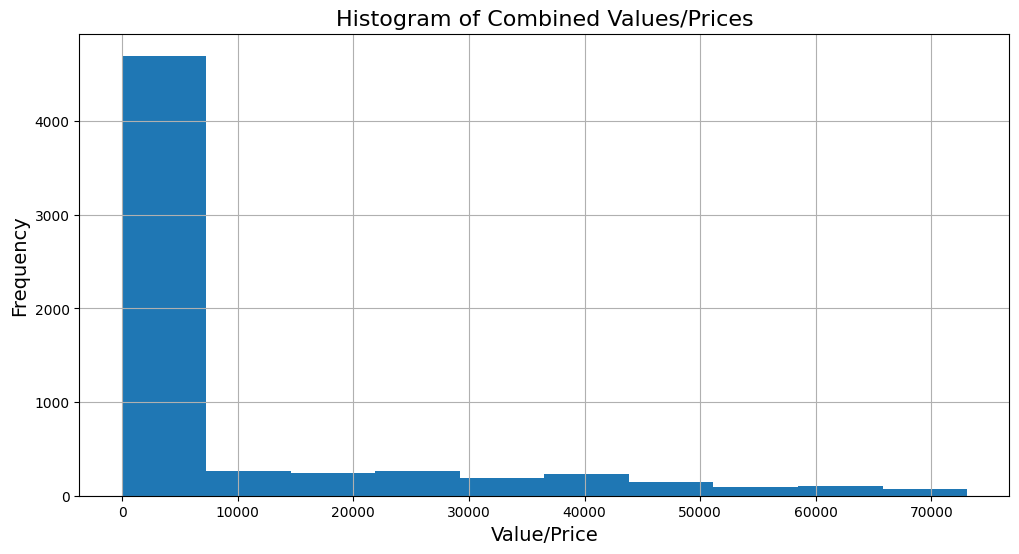

In [33]:
import matplotlib.pyplot as plt

combined_df.hist(column='value', figsize=(12, 6))


plt.xlabel('Value/Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.title('Histogram of Combined Values/Prices', fontsize=16)

plt.show()

In [34]:
combined_df

,time,value,id
1192,2020-01-01,2.179000,Natural Gas
1191,2020-01-02,2.122000,Natural Gas
1190,2020-01-03,2.130000,Natural Gas
1189,2020-01-06,2.135000,Natural Gas
1188,2020-01-07,2.162000,Natural Gas
...,...,...,...
1129,2024-06-28,210.619995,Apple
1130,2024-07-01,216.750000,Apple
1131,2024-07-02,220.270004,Apple
1132,2024-07-03,221.550003,Apple


In [35]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6306 entries, 1192 to 1133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    6306 non-null   datetime64[ns]
 1   value   6306 non-null   float64       
 2   id      6306 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 197.1+ KB


In [36]:
combined_df['value'].isnull().sum()

0

In [37]:
combined_df['value'].info()

<class 'pandas.core.series.Series'>
Index: 6306 entries, 1192 to 1133
Series name: value
Non-Null Count  Dtype  
--------------  -----  
6306 non-null   float64
dtypes: float64(1)
memory usage: 98.5 KB


In [40]:
df_long, y = make_forecasting_frame(combined_df['value'], kind=combined_df['id'], max_timeshift=7, rolling_direction=1)

Rolling: 100%|██████████| 1650/1650 [00:11<00:00, 147.46it/s]


In [41]:
df_long.columns

Index(['id', 'time', 'value', 'kind'], dtype='object')

In [42]:
y

,value
"(id, 1191)",2.122000
"(id, 1190)",2.130000
"(id, 1189)",2.135000
"(id, 1188)",2.162000
"(id, 1187)",2.141000
...,...
"(id, 1129)",210.619995
"(id, 1130)",216.750000
"(id, 1131)",220.270004
"(id, 1132)",221.550003


In [43]:
df_long

,id,time,value,kind
0,"(id, 0)",0,75.087502,Apple
1,"(id, 0)",0,7200.174316,Bitcoin
2,"(id, 0)",0,83.160000,Crude Oil
3,"(id, 0)",0,2397.700000,Gold
5,"(id, 1)",0,75.087502,Apple
...,...,...,...,...
50302,"(id, 1649)",1644,62029.015625,Bitcoin
50303,"(id, 1649)",1645,60173.921875,Bitcoin
50304,"(id, 1649)",1646,56977.703125,Bitcoin
50305,"(id, 1649)",1647,56662.375000,Bitcoin


In [44]:
combined_df.head()

,time,value,id
1192,2020-01-01,2.179,Natural Gas
1191,2020-01-02,2.122,Natural Gas
1190,2020-01-03,2.130,Natural Gas
1189,2020-01-06,2.135,Natural Gas
1188,2020-01-07,2.162,Natural Gas


In [45]:
df_long.head()

,id,time,value,kind
0,"(id, 0)",0,75.087502,Apple
1,"(id, 0)",0,7200.174316,Bitcoin
2,"(id, 0)",0,83.160000,Crude Oil
3,"(id, 0)",0,2397.700000,Gold
5,"(id, 1)",0,75.087502,Apple


In [46]:
df_long['time'].value_counts()

,count
time,
0,39
749,39
755,39
754,39
753,39
...,...
1644,5
1645,4
1646,3


In [47]:
df_long['time'].isnull().sum()

0

In [48]:
df_long['time'].value_counts()

,count
time,
0,39
749,39
755,39
754,39
753,39
...,...
1644,5
1645,4
1646,3


<Axes: >

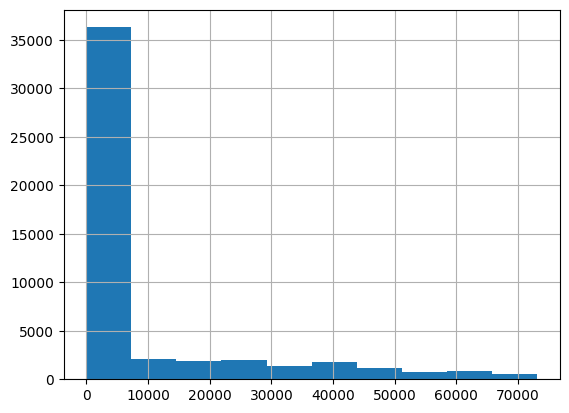

In [49]:
df_long['value'].hist()

In [50]:
extracted_features = extract_features(df_long, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|██████████| 1650/1650 [02:09<00:00, 12.76it/s]


In [51]:
extracted_features

value__variance_larger_than_standard_deviation  \
id 0                                                1.0   
   1                                                1.0   
   2                                                1.0   
   3                                                1.0   
   4                                                1.0   
...                                                 ...   
   1645                                             1.0   
   1646                                             1.0   
   1647                                             1.0   
   1648                                             1.0   
   1649                                             1.0   

         value__has_duplicate_max  value__has_duplicate_min  \
id 0                          0.0                       0.0   
   1                          0.0                       0.0   
   2                          0.0                       0.0   
   3                          0.0                       0.0   
   4                          0.0                       0.0   
...                           ...                       ...   
   1645                       0.0                       0.0   
   1646                       0.0                       0.0   
   1647                       0.0                       0.0   
   1648                       0.0                       0.0   
   1649                       0.0                       0.0   

         value__has_duplicate  value__sum_values  value__abs_energy  \
id 0                      0.0        9756.121818       5.760403e+07   
   1                      0.0       19266.808531       1.120047e+08   
   2                      0.0       29142.293805       1.715788e+08   
   3                      0.0       39046.176047       2.319538e+08   
   4                      0.0       48958.005931       2.923646e+08   
...                       ...                ...                ...   
   1645                   0.0      431182.882813       2.656549e+10   
   1646                   0.0      430545.527344       2.648838e+10   
   1647                   0.0      425918.429688       2.593969e+10   
   1648                   0.0      422260.667969       2.551180e+10   
   1649                   0.0      419676.828126       2.520383e+10   

         value__mean_abs_change  value__mean_change  \
id 0                5518.880377          774.204166   
   1                4389.670445          286.189062   
   2                4182.202316          176.485577   
   3                3847.528477          125.461805   
   4                3645.746885           98.426630   
...                         ...                 ...   
   1645              905.499349          202.956380   
   1646             1082.427734         -238.479818   
   1647             1401.020182         -557.072266   
   1648             1359.034505         -704.167318   
   1649             1334.076172         -729.125651   

         value__mean_second_derivative_central  value__median  ...  \
id 0                              -1202.636703    1240.430000  ...   
   1                               -346.030487      83.940000  ...   
   2                               -201.648617      83.910000  ...   
   3                               -358.892457      83.880000  ...   
   4                               -277.216004      83.630000  ...   
...                                        ...            ...  ...   
   1645                            -161.648828   61604.800781  ...   
   1646                             -57.042969   61604.800781  ...   
   1647                            -376.346094   60887.378906  ...   
   1648                            -210.624219   60887.378906  ...   
   1649                             146.747656   60173.921875  ...   

         value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
id 0                           0.636514                         0.636514   
   1                           1.609

In [52]:
extracted_features.isnull().sum()

,0
value__variance_larger_than_standard_deviation,0
value__has_duplicate_max,0
value__has_duplicate_min,0
value__has_duplicate,0
value__sum_values,0
...,...
value__permutation_entropy__dimension_5__tau_1,1
value__permutation_entropy__dimension_6__tau_1,1
value__permutation_entropy__dimension_7__tau_1,1
value__query_similarity_count__query_None__threshold_0.0,1650


In [53]:
print(extracted_features.isnull().sum())

value__variance_larger_than_standard_deviation                 0
value__has_duplicate_max                                       0
value__has_duplicate_min                                       0
value__has_duplicate                                           0
value__sum_values                                              0
                                                            ... 
value__permutation_entropy__dimension_5__tau_1                 1
value__permutation_entropy__dimension_6__tau_1                 1
value__permutation_entropy__dimension_7__tau_1                 1
value__query_similarity_count__query_None__threshold_0.0    1650
value__mean_n_absolute_max__number_of_maxima_7               458
Length: 783, dtype: int64


In [54]:
from tsfresh.utilities.dataframe_functions import impute

imputed_features = impute(extracted_features)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__fft_coefficient__attr_"real"__coeff_20'
 'value__fft_coefficient__attr_"real"__coeff_21'
 'value__fft_coefficient__attr_"real"__coeff_22'
 'value__fft_coefficient__attr_"real"__coeff_23'
 'value__fft_coefficient__attr_"real"__coeff_24'
 'value__fft_coefficient__attr_"real"__coeff_25'
 'value__fft_coefficient__attr_"real"__coeff_26'
 'value__fft_coefficient__attr_"real"__coeff_27'
 'value__fft_coefficient__attr_"real"__coeff_28'
 'value__fft_coefficient__attr_"real"__coeff_29'
 'value__fft_coefficient__attr_"real"__coeff_30'
 'value__fft_coefficient__attr_"real"__coeff_31'
 'value__fft_coefficient__attr_"real"__coeff_32'
 'value__fft_coefficient__attr_"real"__coeff_33'
 'value__fft_coefficient__attr_"real"__coeff_34'
 'value__fft_coefficient__attr_"real"__coeff_35'
 'value__fft_coefficient__attr_"real"__coeff_36'
 'value__fft_coefficient__attr_"real"__coeff_37'
 'va

In [56]:
# TODO delete the column with 100% null values

In [57]:
null_columns = extracted_features.columns[extracted_features.isnull().all()]

In [58]:
null_columns

Index([], dtype='object')

In [59]:
import plotly.express as px
import plotly.graph_objects as go

# Plotly interactive visualizations
fig = go.Figure()

for name, df in [('Natural Gas', natural_gas_df), ('Gold', gold_df), ('Crude Oil', crude_oil_df), ('Bitcoin', btc_usd_df), ('Apple', aapl_df)]:
    fig.add_trace(go.Scatter(x=df['Date'], y=df_long['value'], mode='lines', name=name))

fig.update_layout(title='Time Series Data Comparison', xaxis_title='Date', yaxis_title='Price')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [61]:
print(f'Number of samples in features: {len(imputed_features)}')
print(f'Number of samples in target: {len(y)}')


Number of samples in features: 1650
Number of samples in target: 6305


In [62]:
print(df_long.head())
print(y.head())

        id  time        value       kind
0  (id, 0)     0    75.087502      Apple
1  (id, 0)     0  7200.174316    Bitcoin
2  (id, 0)     0    83.160000  Crude Oil
3  (id, 0)     0  2397.700000       Gold
5  (id, 1)     0    75.087502      Apple
(id, 1191)    2.122
(id, 1190)    2.130
(id, 1189)    2.135
(id, 1188)    2.162
(id, 1187)    2.141
Name: value, dtype: float64


In [63]:
print(df_long.index)
print(y.index)


Index([    0,     1,     2,     3,     5,     7,     9,    11,    13,     6,
       ...
       50296, 50297, 50298, 50300, 50301, 50302, 50303, 50304, 50305, 50306],
      dtype='int64', length=48658)
Index([('id', 1191), ('id', 1190), ('id', 1189), ('id', 1188), ('id', 1187),
       ('id', 1186), ('id', 1185), ('id', 1184), ('id', 1183), ('id', 1182),
       ...
       ('id', 1124), ('id', 1125), ('id', 1126), ('id', 1127), ('id', 1128),
       ('id', 1129), ('id', 1130), ('id', 1131), ('id', 1132), ('id', 1133)],
      dtype='object', length=6305)


In [64]:
aligned_features = imputed_features.loc[y.index]


In [65]:
from sklearn.model_selection import train_test_split

assert len(aligned_features) == len(y), "Features and target must have the same number of samples"

X_train, X_test, y_train, y_test = train_test_split(aligned_features, y, test_size=0.2, random_state=42)


In [66]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [67]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1518817244202754.0


In [71]:
!pip install plotly

In [70]:
import plotly.express as px

importances = model.coef_
feature_names = imputed_features.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Time Series Plot
fig_ts = px.line(combined_df, x='time', y='value', color='id', title='Time Series Data')
fig_ts.show()

# Feature Importance Plot
fig_importance = px.bar(feature_importance, x='Feature', y='Importance', title='Feature Importance')
fig_importance.update_xaxes(title_text='Feature')
fig_importance.update_yaxes(title_text='Importance')
fig_importance.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [72]:
!pip install bokeh


In [75]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

output_notebook()

# Time Series Plot
source = ColumnDataSource(combined_df)
p = figure(x_axis_type='datetime', title='Time Series Data')
p.line(x='time', y='value', source=source, legend_field='id')
show(p)

# Feature Importance Plot (example using feature importance from a model)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
p2 = figure(x_range=feature_importance['Feature'], title='Feature Importance', toolbar_location=None)
p2.vbar(x='Feature', top='Importance', source=feature_importance, width=0.9)
p2.xaxis.major_label_orientation = 1.2
show(p2)


In [108]:
!pip install matplotlib


In [112]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

output_notebook()

# Prepare the data
unique_ids = combined_df['id'].unique()
num_ids = len(unique_ids)

# Generate a custom color palette using Matplotlib
def generate_colors(num_colors):
    """Generate a list of distinct colors."""
    cmap = plt.get_cmap('tab20')  # Choose a colormap
    return [cmap(i / num_colors) for i in range(num_colors)]

# Create a color palette
palette = generate_colors(num_ids)

# Convert RGB to HEX format
palette_hex = [mcolors.to_hex(color) for color in palette]

# Prepare the data source
source = ColumnDataSource(combined_df)

# Create the time series plot
p = figure(x_axis_type='datetime', title='Time Series Data', width=800, height=400)

# Define line styles and markers
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']
markers = ['circle', 'square', 'triangle', 'diamond']

# Ensure we have enough styles and markers
line_styles *= (num_ids // len(line_styles)) + 1
markers *= (num_ids // len(markers)) + 1

# Add lines with different styles and markers
for i, id_value in enumerate(unique_ids):
    df_id = combined_df[combined_df['id'] == id_value]
    p.line(df_id['time'], df_id['value'], legend_label=str(id_value),
           line_width=2, line_dash=line_styles[i % len(line_styles)],
           color=palette_hex[i % len(palette_hex)])
    p.scatter(df_id['time'], df_id['value'], legend_label=str(id_value),
              marker=markers[i % len(markers)], size=8, color=palette_hex[i % len(palette_hex)])

# Add legend and labels
p.legend.title = 'ID'
p.legend.label_text_font_size = '10pt'
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Value'
p.xaxis.major_label_orientation = 1.2

show(p)

# Feature Importance Plot (example using feature importance from a model)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feature_importance.nlargest(10, 'Importance')  # Select top 10 features

p2 = figure(x_range=top_features['Feature'].astype(str), title='Feature Importance', toolbar_location=None, width=800, height=400)
p2.vbar(x='Feature', top='Importance', source=top_features, width=0.9, color='blue')
p2.xaxis.major_label_orientation = 1.2
p2.yaxis.axis_label = 'Importance'
p2.xaxis.axis_label = 'Feature'

show(p2)


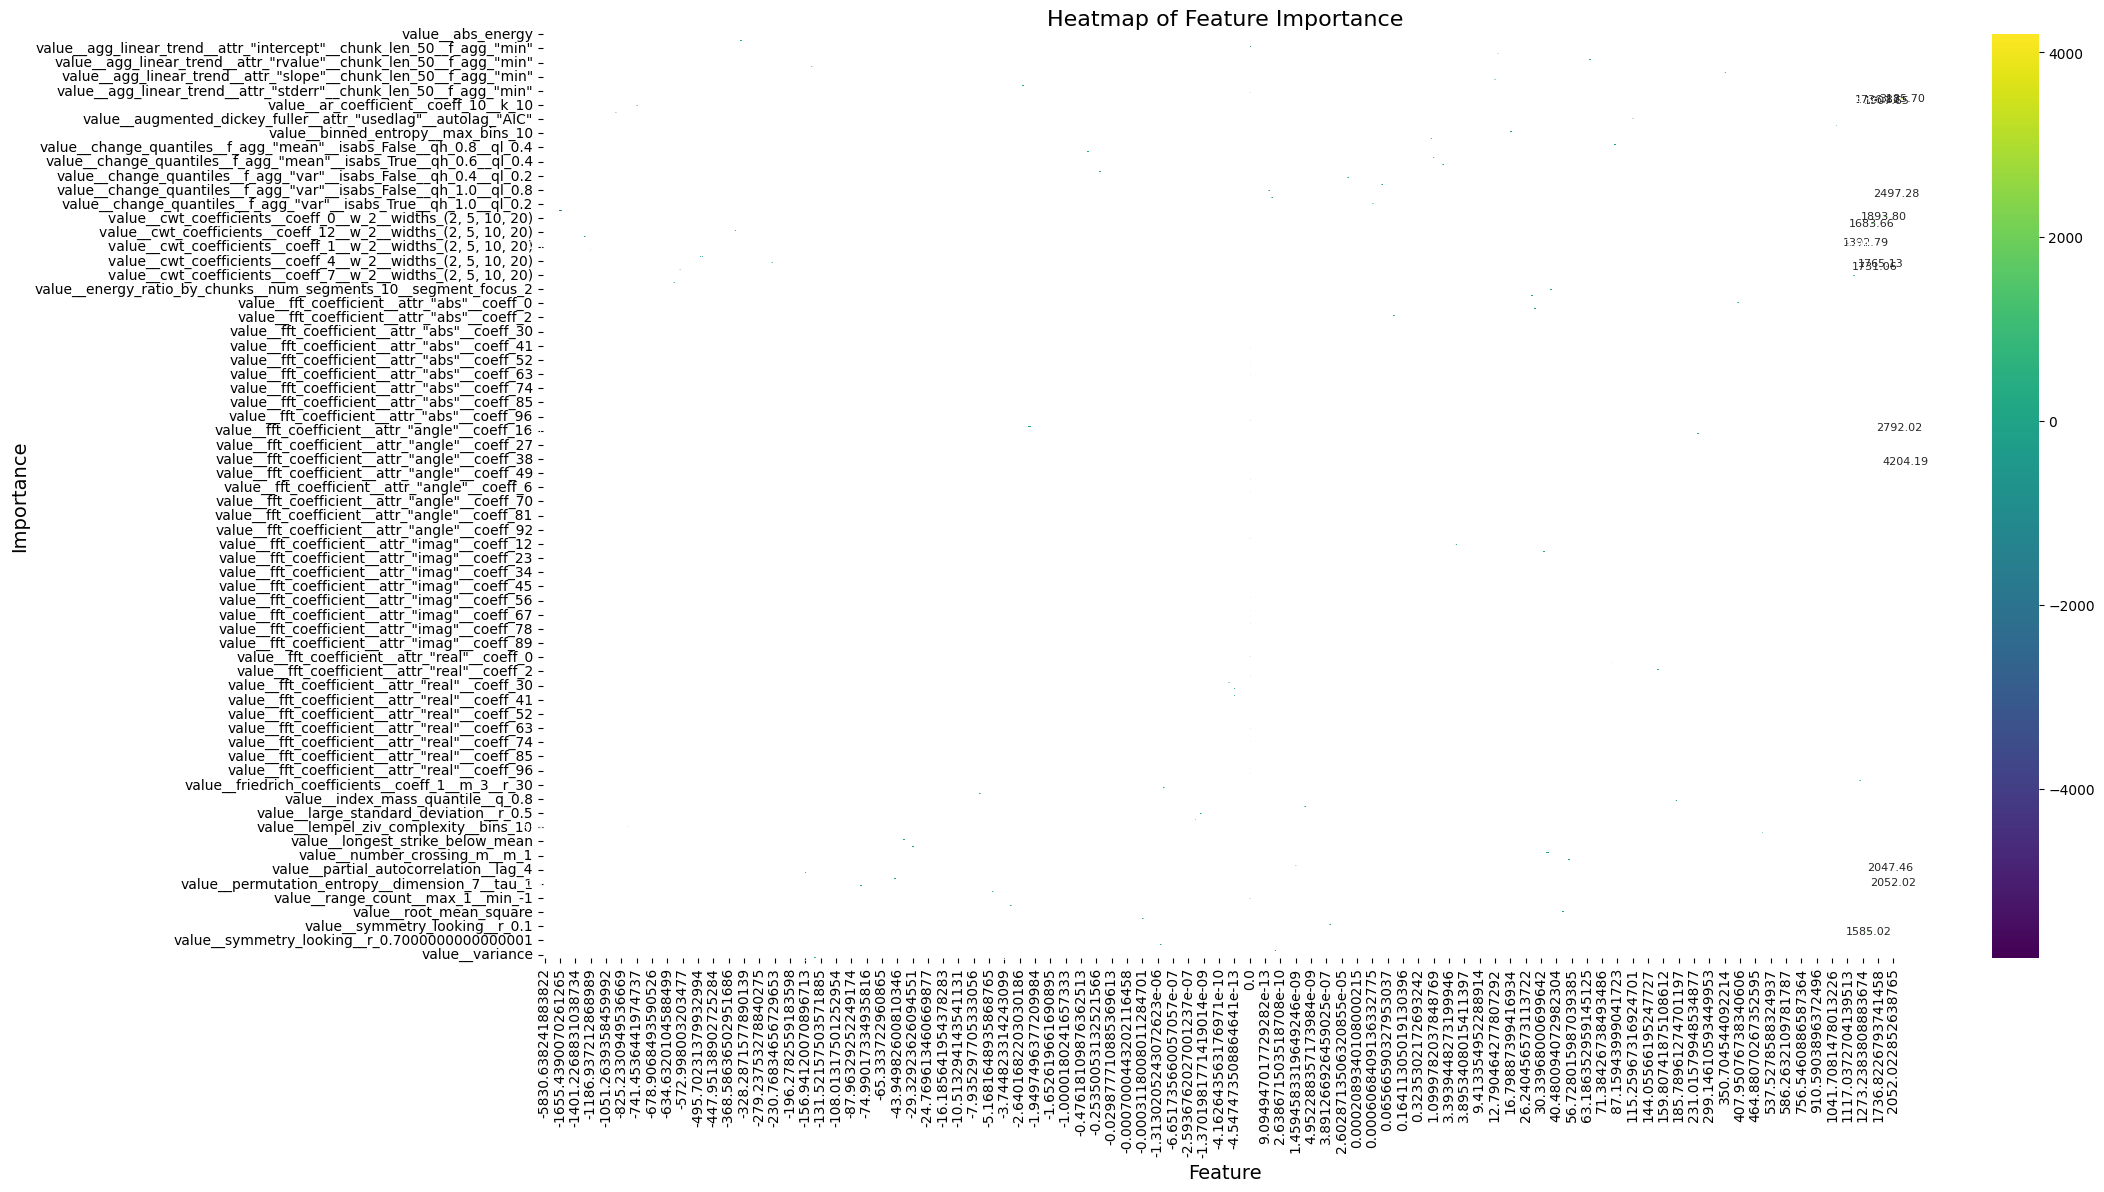

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare feature importance data for heatmap
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.pivot(index='Feature', columns='Importance', values='Importance')

# Create heatmap
plt.figure(figsize=(22, 12))
heatmap = sns.heatmap(
    feature_importance,
    annot=True,
    cmap='viridis',
    cbar=True,
    fmt='.2f',
    linewidths=.5,
    annot_kws={"size": 8}  # Set font size for annotations
)

# Adjust font sizes
plt.title('Heatmap of Feature Importance', fontsize=16)  # Title font size
plt.xlabel('Feature', fontsize=14)  # X-axis label font size
plt.ylabel('Importance', fontsize=14)  # Y-axis label font size
plt.xticks(rotation=90, fontsize=10)  # X-axis ticks font size
plt.yticks(rotation=0, fontsize=10)  # Y-axis ticks font size

# Show the plot
plt.show()


In [96]:
print(feature_importance.columns)


Index([ -5830.638241883822, -2938.9428707418647, -2385.7800460870967,
        -2072.027241918338, -1666.5925063690975, -1655.4390070261265,
         -1626.54578048617, -1495.5658379556398, -1465.9936523330814,
       -1450.2350138766685,
       ...
        1736.8226793741458,  1765.1290921204782,  1893.8027004898897,
        1907.6513872372252,  2047.4601313986464,   2052.022852638765,
          2497.27624426618,    2792.02287978019,  3185.6970497487796,
          4204.18578812986],
      dtype='float64', name='Importance', length=445)


In [97]:
import pandas as pd

# Construct the feature importance DataFrame correctly
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Check the DataFrame structure
print(feature_importance.head())


                                          Feature   Importance
0  value__variance_larger_than_standard_deviation    -3.936721
1                        value__has_duplicate_max  -106.295775
2                        value__has_duplicate_min -1257.629280
3                            value__has_duplicate   123.768769
4                               value__sum_values   159.807419


In [98]:
# Sort by importance and select top features
top_features = feature_importance.nlargest(10, 'Importance').reset_index(drop=True)


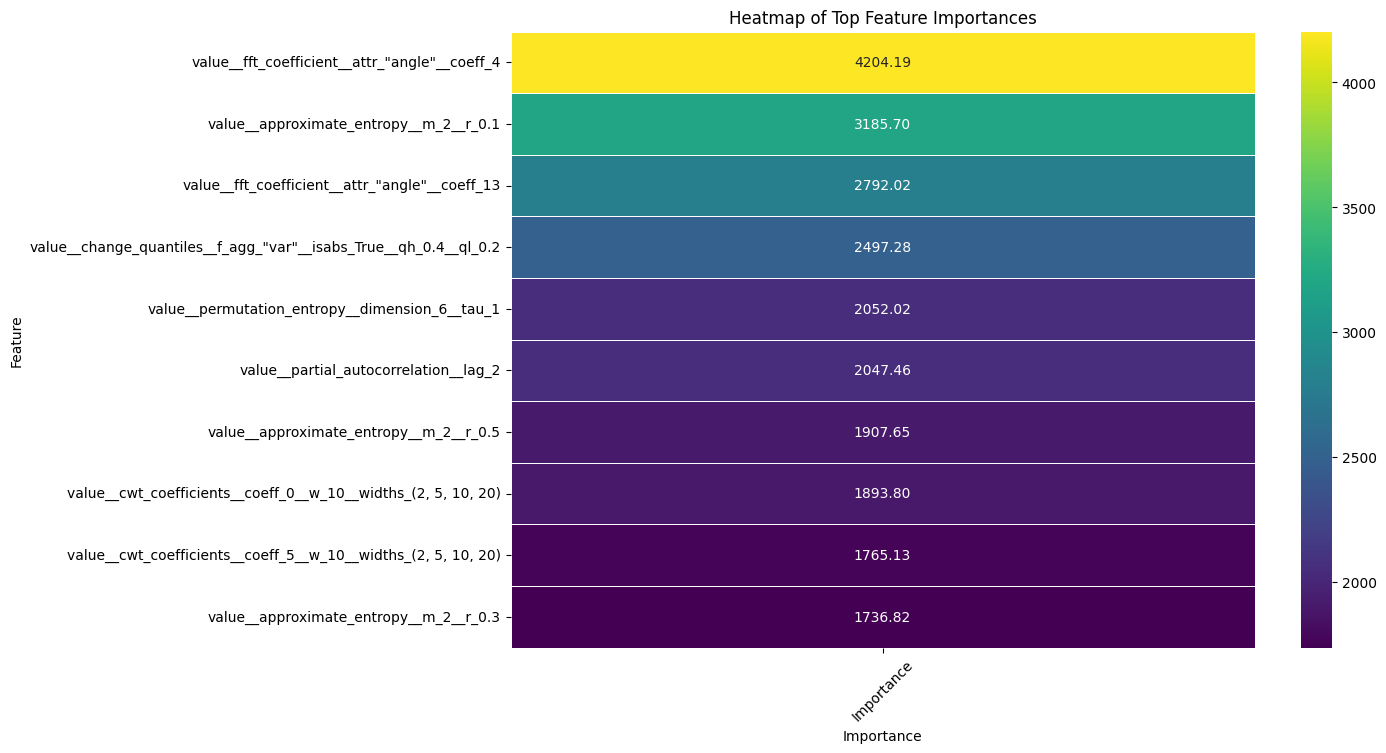

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for heatmap
top_features = top_features.set_index('Feature')  # Set 'Feature' as index for better plotting
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', cbar=True, fmt='.2f', linewidths=.5)
plt.title('Heatmap of Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Show the plot
plt.show()


In [101]:
import altair as alt
import pandas as pd

# Ensure the DataFrame is constructed correctly
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Select the top 10 features
top_features = feature_importance.nlargest(10, 'Importance')

# Plot using Altair
chart = alt.Chart(top_features).mark_bar().encode(
    x=alt.X('Feature:N', sort='-y', title='Feature'),
    y=alt.Y('Importance:Q', title='Importance'),
    tooltip=['Feature', 'Importance']
).properties(
    title='Top 10 Features by Importance',
    width=600,
    height=400
)

# Show the plot
chart.display()


/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.



alt.Chart(...)